In [21]:
from classiq import *
from classiq.applications.chemistry import PauliOperator
from classiq.execution import (
    ClassiqBackendPreferences,
    ClassiqSimulatorBackendNames,
    ExecutionPreferences,
    ExecutionSession
)

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
%matplotlib inline
from scipy.optimize import minimize

from itertools import product

In [ ]:
# !pip install neo4j

In [ ]:
# from neo4j import GraphDatabase
# import networkx as nx

# # g1 = nx.generators.erdos_renyi_graph(8, 0.35, seed=14)

# # driver = GraphDatabase.driver(uri, auth=(username, password))

# # def create_nodes(tx, node_id):
# #     tx.run("MERGE (n:Node {name: $name})", name=f"Node {node_id}")

# # def create_relationship(tx, id1, id2):
# #     tx.run("""
# #         MATCH (a:Node {name: $name1}), (b:Node {name: $name2})
# #         MERGE (a)-[:CONNECTED_TO]->(b)
# #     """, name1=f"Node {id1}", name2=f"Node {id2}")

# # with driver.session() as session:
# #     # Create nodes
# #     for node in g1.nodes():
# #         session.write_transaction(create_nodes, node)
    
# #     # Create edges
# #     for edge in g1.edges():
# #         session.write_transaction(create_relationship, edge[0], edge[1])

# # driver.close()

In [ ]:

# def get_edges(tx):
#     result = tx.run("""
#         MATCH (a:Node)-[:CONNECTED_TO]->(b:Node)
#         RETURN a.name AS from_node, b.name AS to_node
#     """)
#     return [(record["from_node"], record["to_node"]) for record in result]

# with driver.session() as session:
#     edges = session.read_transaction(get_edges)

# node_names = sorted({name for edge in edges for name in edge})

# name_to_index = {name: idx for idx, name in enumerate(node_names)}

# n = len(node_names)
# adj1 = np.zeros((n, n), dtype=int)

# for from_node, to_node in edges:
#     i = name_to_index[from_node]
#     j = name_to_index[to_node]
#     adj1[i, j] = 1

# print("Adjacency Matrix:")
# print(adj1)


In [2]:
# BUILD ADJACENCY MATRIX
def checkboard(n):
    c = np.arange(n//2)*2
    c = np.tile(c, len(c)), np.repeat(c + 1, len(c))
    m = np.zeros((n, n), dtype=int)
    m[c] = 1
    m[(c[1], c[0])] = 1
    return m

def rnd_perm_mat(n, *, seed=None):
    rng = np.random.default_rng(seed=seed)
    m = np.eye(n, dtype=int)
    rng.shuffle(m)
    return m

/tmp/ipykernel_216/899343001.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj1 = np.array(nx.adjacency_matrix(g1).todense())


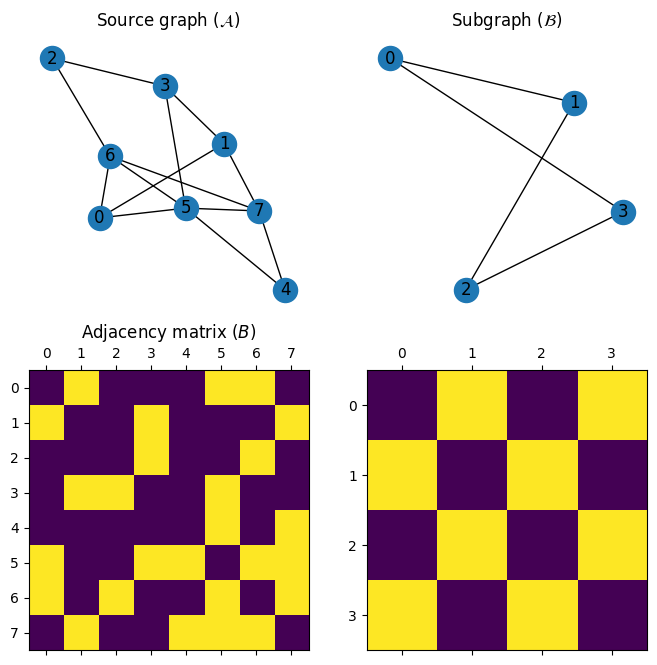

In [3]:
# BUILD GRAPH
g1 = nx.generators.erdos_renyi_graph(8, 0.35, seed=14)
adj1 = np.array(nx.adjacency_matrix(g1).todense())

adj2 = checkboard(4)
g2 = nx.from_numpy_matrix(adj2)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
nx.draw(g1, with_labels=True, ax=axs[0][0])
nx.draw(g2, with_labels=True, ax=axs[0][1])
axs[0][0].set_title('Source graph ($\\mathcal{A}$)')
axs[0][1].set_title('Subgraph ($\\mathcal{B}$)')
axs[1][0].set_title('Adjacency matrix ($A$)')
axs[1][0].matshow(adj1)
axs[1][0].set_title('Adjacency matrix ($B$)')
axs[1][1].matshow(adj2)
plt.show()

In [4]:
# UTILS
def _pow2_shaped_mat_validation(mat):
    mat = np.asarray(mat)
    assert mat.ndim == 2
    assert mat.shape[0] == mat.shape[1]
    assert all(map(_is_pow_2, mat.shape))
    return mat

def _is_pow_2(v: int):
    assert isinstance(v, int)
    return (bin(v).count("1") == 1) or (v == 0)


In [5]:
# FLATTEN ADJECENCY
# SHOULD BE POWER OF 2
def adjacency_flatten(adj: np.ndarray, shape=None):
    adj = np.round(adj) != 0
    assert adj.ndim == 2 and adj.shape[0] == adj.shape[1]
    adj = adj if shape is None else matrix_fill_zeroes(adj, shape=shape)
    assert _is_pow_2(len(adj))
    adj = adj.flatten()
    adj = np.concatenate([np.zeros_like(adj), adj])
    adj = np.exp(1j * adj * np.pi)
    adj = np.diag(adj)
    return adj

def matrix_fill_zeroes(mat, shape):
    mat = np.asarray(mat)
    ret = np.zeros(shape, dtype=mat.dtype)
    ret[: mat.shape[0], : mat.shape[1]] = mat
    return ret

adjacency_flatten(adj1).shape


(128, 128)

In [6]:
# TOPOLOGY
def expand_topology(n, topology="circular") -> np.ndarray:
    if isinstance(topology, str):
        if topology in {"linear", "circular"}:
            v = np.arange(n - 1)
            v = np.stack([v, v + 1]).T
            if topology == "circular" and n > 2:
                v = np.concatenate([v, np.array([[n - 1, 0]])], axis=0)
            topology = v
        else:
            raise ValueError(f"Unrecognized topology: {topology}")
    topology = np.asarray(topology)
    assert topology.ndim == 2 and topology.shape[1] == 2
    return topology

In [7]:
# BUILD HAMILTONIAN
def observable(n: int):
    n = int(n)
    coeff = -1 / (2 ** n)
    pauli_labels = [''.join(bits) for bits in product('IZ', repeat=n)]
    mp = []
    for l in pauli_labels:
        pt = []
        for c in l:
            if c == 'I':
                pt.append(0)
            elif c=='Z':
                pt.append(3)
            else:
                print("error only I and Z as observable")
                return
        mp.append(pt)
    coeffs = np.full(len(pauli_labels), coeff)
    # return [(l, c) for l, c in zip(pauli_labels, coeffs)]
    return [PauliTerm(l, c) for l, c in zip(mp, coeffs)]

{'IIIIIII': -0.0078125, 'IIIIIIZ': -0.0078125, 'IIIIIZI': -0.0078125, 'IIIIIZZ': -0.0078125, 'IIIIZII': -0.0078125, 'IIIIZIZ': -0.0078125, 'IIIIZZI': -0.0078125, 'IIIIZZZ': -0.0078125, 'IIIZIII': -0.0078125, 'IIIZIIZ': -0.0078125, 'IIIZIZI': -0.0078125, 'IIIZIZZ': -0.0078125, 'IIIZZII': -0.0078125, 'IIIZZIZ': -0.0078125, 'IIIZZZI': -0.0078125, 'IIIZZZZ': -0.0078125, 'IIZIIII': -0.0078125, 'IIZIIIZ': -0.0078125, 'IIZIIZI': -0.0078125, 'IIZIIZZ': -0.0078125, 'IIZIZII': -0.0078125, 'IIZIZIZ': -0.0078125, 'IIZIZZI': -0.0078125, 'IIZIZZZ': -0.0078125, 'IIZZIII': -0.0078125, 'IIZZIIZ': -0.0078125, 'IIZZIZI': -0.0078125, 'IIZZIZZ': -0.0078125, 'IIZZZII': -0.0078125, 'IIZZZIZ': -0.0078125, 'IIZZZZI': -0.0078125, 'IIZZZZZ': -0.0078125, 'IZIIIII': -0.0078125, 'IZIIIIZ': -0.0078125, 'IZIIIZI': -0.0078125, 'IZIIIZZ': -0.0078125, 'IZIIZII': -0.0078125, 'IZIIZIZ': -0.0078125, 'IZIIZZI': -0.0078125, 'IZIIZZZ': -0.0078125, 'IZIZIII': -0.0078125, 'IZIZIIZ': -0.0078125, 'IZIZIZI': -0.0078125, 'IZIZIZZ':

In [8]:
# VARIABLES
adj_shape = adjacency_flatten(adj1).shape[0]
nqubits = np.log2(adj_shape)

topology = expand_topology(nqubits // 2)

parameters_per_block = 5
total_parameters = len(topology)*parameters_per_block

no_h = int(np.log2(len(adj2)))

hamiltonian = observable(nqubits)
print(hamiltonian)

seed = 10283764
rng = np.random.default_rng(seed=seed)

[PauliTerm(pauli=[0, 0, 0, 0, 0, 0, 0], coefficient=-0.0078125), PauliTerm(pauli=[0, 0, 0, 0, 0, 0, 3], coefficient=-0.0078125), PauliTerm(pauli=[0, 0, 0, 0, 0, 3, 0], coefficient=-0.0078125), PauliTerm(pauli=[0, 0, 0, 0, 0, 3, 3], coefficient=-0.0078125), PauliTerm(pauli=[0, 0, 0, 0, 3, 0, 0], coefficient=-0.0078125), PauliTerm(pauli=[0, 0, 0, 0, 3, 0, 3], coefficient=-0.0078125), PauliTerm(pauli=[0, 0, 0, 0, 3, 3, 0], coefficient=-0.0078125), PauliTerm(pauli=[0, 0, 0, 0, 3, 3, 3], coefficient=-0.0078125), PauliTerm(pauli=[0, 0, 0, 3, 0, 0, 0], coefficient=-0.0078125), PauliTerm(pauli=[0, 0, 0, 3, 0, 0, 3], coefficient=-0.0078125), PauliTerm(pauli=[0, 0, 0, 3, 0, 3, 0], coefficient=-0.0078125), PauliTerm(pauli=[0, 0, 0, 3, 0, 3, 3], coefficient=-0.0078125), PauliTerm(pauli=[0, 0, 0, 3, 3, 0, 0], coefficient=-0.0078125), PauliTerm(pauli=[0, 0, 0, 3, 3, 0, 3], coefficient=-0.0078125), PauliTerm(pauli=[0, 0, 0, 3, 3, 3, 0], coefficient=-0.0078125), PauliTerm(pauli=[0, 0, 0, 3, 3, 3, 3], 

In [9]:
# HCPH & HPH
@qfunc
def hcph(q0: QBit, q1:QBit, phi: CReal):
    within_apply(lambda: H(q1), lambda: CPHASE(phi, q0, q1))

@qfunc
def hph(q0: QBit, phi: CReal):
    within_apply(lambda: H(q0), lambda: PHASE(phi, q0))

In [10]:
# BLOCK
@qfunc
def block(q0: QBit, q1: QBit, parameters: CArray[CReal, 5]):
    hph(q0, parameters[0])

    H(q1)
    PHASE(parameters[1], q1)
    CPHASE(parameters[2], q0, q1)
    H(q1)

    hcph(q1, q0, parameters[3])
    hcph(q0, q1, parameters[4])

In [11]:
# PERMUTATION BLOCK
@qfunc
def permutation(target: QArray[QBit], parameters: CArray[CReal, total_parameters]):
    for t, p in zip(topology, range(0, 15, 5)):
        block(target[t[0]], target[t[1]], parameters[p:p+5])


In [12]:
# MAIN
@qfunc
def main(a: Output[QArray[QBit]], b: Output[QArray[QBit]], ancilla: Output[QBit], parameters: CArray[CReal, total_parameters]):
    x = QArray()

    allocate(nqubits//2, a)
    allocate(nqubits//2, b)
    allocate(1, ancilla)

    # hadamard layer
    hadamard_transform(a[0:no_h])
    hadamard_transform(b[0:no_h])
    H(ancilla)

    # permutation dg layer
    if(adj1.shape != adj2.shape):
        invert(lambda: permutation(a, parameters))
        invert(lambda: permutation(b, parameters))

    # unitary adjacency 1
    bind([a, b, ancilla], x)
    unitary(adjacency_flatten(adj1), x)
    bind(x, [a, b, ancilla])

    # permutation layer
    permutation(a, parameters)
    permutation(b, parameters)

    # unitary adjacency 2
    bind([a, b, ancilla], x)
    unitary(adjacency_flatten(adj2, shape=adj1.shape), x)
    bind(x, [a, b, ancilla])

    # hadamard layer
    hadamard_transform(a[0:no_h])
    hadamard_transform(b[0:no_h])
    H(ancilla)



In [14]:
qmod = create_model(main)


In [30]:

execution_preferences = ExecutionPreferences(
    num_shots=1024,
    # backend_preferences = ClassiqBackendPreferences(
    #     backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
    # )
)
qmod = set_execution_preferences(qmod, execution_preferences)

In [31]:
qprog = synthesize(qmod)

In [32]:
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/2vzqVWyxnZGO5NL9pXQZDMVLRFQ?login=True&version=0.75.0


In [33]:
def cf(p):
    return 1-np.sqrt(p)

def black_box_obj(es):
    def f(p):
        p_list = list(map(float, p))
        result = es.sample(parameters={"parameters": p_list})
        return cf(result.counts['0'*int(nqubits)]/result.num_shots)
    return f

In [39]:
def trail():
    initial_points = (rng.uniform(size=total_parameters) - 1/2) * np.pi
    print(initial_points)
    print("started")
    with ExecutionSession(qprog) as execution_session:
        fun = black_box_obj(execution_session)
        sample = minimize(fun, initial_points, method='COBYLA', options={'maxiter': 1000, 'disp': True})
        print("ended")
        return sample

In [40]:

res = trail()

[-1.13576267 -0.53279051 -1.34449798 -0.58188076 -0.93917065  1.11296079
  0.48011713 -0.64355005 -0.82954955  0.29270142  0.82013751  0.01020274
  0.18460621 -0.34962711  1.56740618]
started


ended
   Normal return from subroutine COBYLA


   NFVALS =  131   F = 1.726124E-01    MAXCV = 0.000000E+00
   X = 9.839223E-02  -5.591713E-01  -9.511574E-01   5.173006E-01  -9.403430E-01
       1.197899E+00   2.150412E+00  -2.872553E-01   1.983130E-01   1.291088E+00
       5.505498E-01  -1.412110E-01   2.012765E-01  -3.452703E-01   1.580811E+00


In [42]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.1726123565703921
       x: [ 9.839e-02 -5.592e-01 ... -3.453e-01  1.581e+00]
    nfev: 131
   maxcv: 0.0

In [13]:

@qfunc
def main(t: Output[QArray[QBit]], parameters: CArray[CReal, total_parameters]):
    allocate(nqubits//2, t)
    hadamard_transform(t)
    permutation(t, parameters)

In [14]:
qm = create_model(main)
qp = synthesize(qm)

In [15]:
optimal_parameters = [9.839223E-02, -5.591713E-01, -9.511574E-01, 5.173006E-01, -9.403430E-01,1.197899E+00, 2.150412E+00, -2.872553E-01, 1.983130E-01, 1.291088E+00,5.505498E-01, -1.412110E-01, 2.012765E-01, -3.452703E-01, 1.580811E+00]

def thetas_to_prob(x) -> np.ndarray:
    x = np.asarray(x) / np.pi
    x = np.abs(x)
    r = np.modf(x)
    r = r[0], r[1] % 2
    return np.abs(r[0] - r[1])

def sample_exact_thetas(v, *, n=1, seed=None):
    v = thetas_to_prob(v)
    rng = np.random.default_rng(seed)
    prob = rng.uniform(size=(n, len(v)))
    v = (prob < v) * np.pi
    return v

def perm_to_2line(mat, *, inverse=False) -> np.ndarray:
    mat = np.stack(np.nonzero(mat))
    mat = mat if inverse else mat[::-1]
    return mat[:, np.argsort(mat[0])]

def plot_solution_edges(g1, *, pos, perm, ax):
    vx_sel = perm_to_2line(perm, inverse=True)
    vx_sel = vx_sel[1, :len(adj2)]
    nx.draw_networkx_edges(g1.subgraph(vx_sel), pos,
                           width=5.0, alpha=0.5, ax=ax)


In [ ]:
def cost_f(adj1, adj2, p):
    m = p @ adj1 @ p.T
    m = m[:len(adj2), :len(adj2)]
    return np.linalg.norm(m - adj2)

op = sample_exact_thetas(optimal_parameters, n=32, seed=seed)

In [16]:
def get_P(counts):
    sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

    p = [int(k, 2) for k in sorted_counts.keys()]
    print(p)

    N = len(p)
    P = np.zeros((N, N), dtype=int)

    for i in range(N):
        P[i][p[i]] = 1

    return P

In [17]:
ex = ExecutionSession(qp)
min_cost = np.inf
for v in op:
    v_list = list(map(float, v))
    result = ex.sample(parameters={"parameters": v_list})
    print(result)
    P = get_P(result.counts)
    cost = cost_f(adj1, adj2, P)
    if cost < min_cost:
        _P = P
        if cost < 1.:
            break



vendor_format_result={} counts={'100': 234, '010': 289, '000': 250, '111': 236, '011': 253, '101': 250, '110': 270, '001': 266} counts_lsb_right=True probabilities={} parsed_states={'100': {'t': [0, 0, 1]}, '010': {'t': [0, 1, 0]}, '000': {'t': [0, 0, 0]}, '111': {'t': [1, 1, 1]}, '011': {'t': [1, 1, 0]}, '101': {'t': [1, 0, 1]}, '110': {'t': [0, 1, 1]}, '001': {'t': [1, 0, 0]}} histogram=None output_qubits_map={'t': (0, 1, 2)} state_vector=None parsed_state_vector_states=None physical_qubits_map={'t': (0, 1, 2)} num_shots=2048
[2, 6, 1, 3, 0, 5, 7, 4]
vendor_format_result={} counts={'001': 262, '000': 231, '010': 256, '110': 244, '011': 268, '111': 274, '101': 265, '100': 248} counts_lsb_right=True probabilities={} parsed_states={'001': {'t': [1, 0, 0]}, '000': {'t': [0, 0, 0]}, '010': {'t': [0, 1, 0]}, '110': {'t': [0, 1, 1]}, '011': {'t': [1, 1, 0]}, '111': {'t': [1, 1, 1]}, '101': {'t': [1, 0, 1]}, '100': {'t': [0, 0, 1]}} histogram=None output_qubits_map={'t': (0, 1, 2)} state_vec

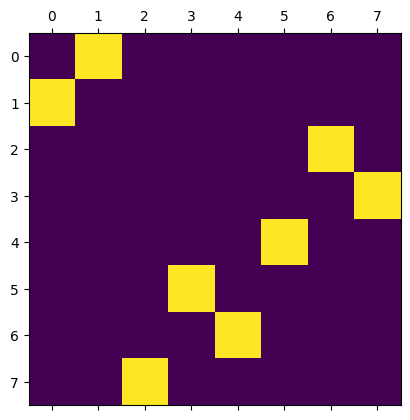

In [18]:
plt.matshow(_P, vmin=0, vmax=1)
plt.show()

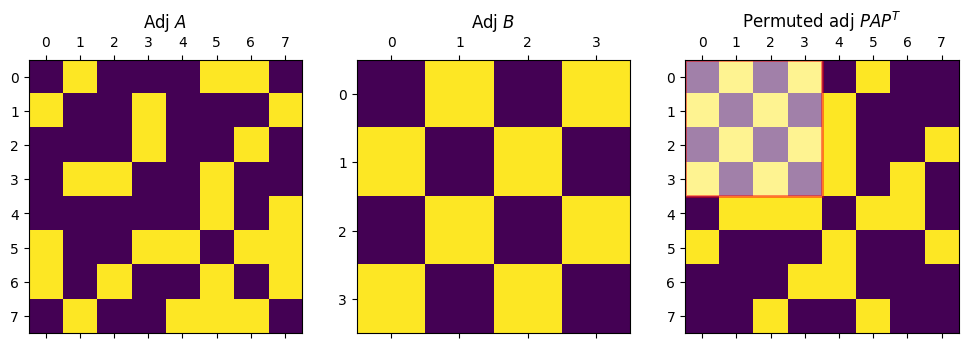

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.patch.set_facecolor('white')
axs[0].matshow(adj1)
axs[0].set_title('Adj $A$')
axs[1].matshow(adj2)
axs[1].set_title('Adj $B$')
axs[2].matshow(_P @ adj1 @ _P.T)
axs[2].set_title('Permuted adj $PAP^T$')
rect = patches.Rectangle((-0.5, -0.5), len(adj2), len(adj2), linewidth=2,
                         edgecolor='red', facecolor='white', alpha=0.5)
axs[2].add_patch(rect)
plt.show()

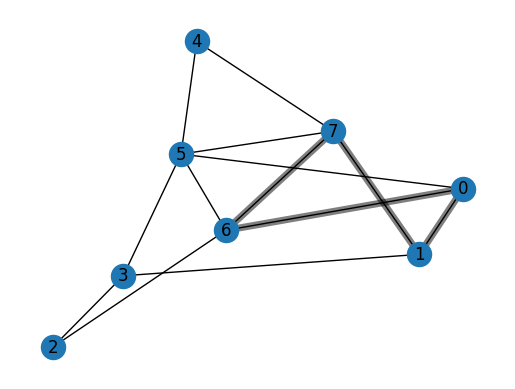

In [28]:
fig, ax = plt.subplots()
g1_pos = nx.spring_layout(g1, seed=42)  # or any other layout
nx.draw(g1, g1_pos, with_labels=True, ax=ax)
plot_solution_edges(g1, pos=g1_pos, perm=_P, ax=ax)
